# Work with the .mod files

In [2]:
notes = """
Protracker 1.1B Song/Module Format:
-----------------------------------

Offset  Bytes  Description
------  -----  -----------
   0     20    Songname. Remember to put trailing null bytes at the end...

Information for sample 1-31:

Offset  Bytes  Description
------  -----  -----------
  20     22    Samplename for sample 1. Pad with null bytes.
  42      2    Samplelength for sample 1. Stored as number of words.
               Multiply by two to get real sample length in bytes.
  44      1    Lower four bits are the finetune value, stored as a signed
               four bit number. The upper four bits are not used, and
               should be set to zero.
               Value:  Finetune:
                 0        0
                 1       +1
                 2       +2
                 3       +3
                 4       +4
                 5       +5
                 6       +6
                 7       +7
                 8       -8
                 9       -7
                 A       -6
                 B       -5
                 C       -4
                 D       -3
                 E       -2
                 F       -1

  45      1    Volume for sample 1. Range is $00-$40, or 0-64 decimal.
  46      2    Repeat point for sample 1. Stored as number of words offset
               from start of sample. Multiply by two to get offset in bytes.
  48      2    Repeat Length for sample 1. Stored as number of words in
               loop. Multiply by two to get replen in bytes.

Information for the next 30 samples starts here. It's just like the info for
sample 1.

Offset  Bytes  Description
------  -----  -----------
  50     30    Sample 2...
  80     30    Sample 3...
   .
   .
   .
 890     30    Sample 30...
 920     30    Sample 31...

Offset  Bytes  Description
------  -----  -----------
 950      1    Songlength. Range is 1-128.
 951      1    Well... this little byte here is set to 127, so that old
               trackers will search through all patterns when loading.
               Noisetracker uses this byte for restart, but we don't.
 952    128    Song positions 0-127. Each hold a number from 0-63 that
               tells the tracker what pattern to play at that position.
1080      4    The four letters "M.K." - This is something Mahoney & Kaktus
               inserted when they increased the number of samples from
               15 to 31. If it's not there, the module/song uses 15 samples
               or the text has been removed to make the module harder to
               rip. Startrekker puts "FLT4" or "FLT8" there instead.

Offset  Bytes  Description
------  -----  -----------
1084    1024   Data for pattern 00.
   .
   .
   .
xxxx  Number of patterns stored is equal to the highest patternnumber
      in the song position table (at offset 952-1079).

Each note is stored as 4 bytes, and all four notes at each position in
the pattern are stored after each other.

00 -  chan1  chan2  chan3  chan4
01 -  chan1  chan2  chan3  chan4
02 -  chan1  chan2  chan3  chan4
etc.

Info for each note:

 _____byte 1_____   byte2_    _____byte 3_____   byte4_
/                \ /      \  /                \ /      \
0000          0000-00000000  0000          0000-00000000

Upper four    12 bits for    Lower four    Effect command.
bits of sam-  note period.   bits of sam-
ple number.                  ple number.

Periodtable for Tuning 0, Normal
  C-1 to B-1 : 856,808,762,720,678,640,604,570,538,508,480,453
  C-2 to B-2 : 428,404,381,360,339,320,302,285,269,254,240,226
  C-3 to B-3 : 214,202,190,180,170,160,151,143,135,127,120,113

To determine what note to show, scan through the table until you find
the same period as the one stored in byte 1-2. Use the index to look
up in a notenames table.

This is the data stored in a normal song. A packed song starts with the
four letters "PACK", but i don't know how the song is packed: You can
get the source code for the cruncher/decruncher from us if you need it,
but I don't understand it; I've just ripped it from another tracker...

In a module, all the samples are stored right after the patterndata.
To determine where a sample starts and stops, you use the sampleinfo
structures in the beginning of the file (from offset 20). Take a look
at the mt_init routine in the playroutine, and you'll see just how it
is done.

https://www.lim.di.unimi.it/IEEE/VROS/MOD.HTM

***********************************************************************
Protracker V2.3A/3.01 Effect Commands
----------------------------------------------------------------------------
0 - Normal play or Arpeggio             0xy : x-first halfnote add, y-second
1 - Slide Up                            1xx : upspeed
2 - Slide Down                          2xx : downspeed
3 - Tone Portamento                     3xx : up/down speed
4 - Vibrato                             4xy : x-speed,   y-depth
5 - Tone Portamento + Volume Slide      5xy : x-upspeed, y-downspeed
6 - Vibrato + Volume Slide              6xy : x-upspeed, y-downspeed
7 - Tremolo                             7xy : x-speed,   y-depth
8 - NOT USED
9 - Set SampleOffset                    9xx : offset (23 -> 2300)
A - VolumeSlide                         Axy : x-upspeed, y-downspeed
B - Position Jump                       Bxx : songposition
C - Set Volume                          Cxx : volume, 00-40
D - Pattern Break                       Dxx : break position in next patt
E - E-Commands                          Exy : see below...
F - Set Speed                           Fxx : speed (00-1F) / tempo (20-FF)
----------------------------------------------------------------------------
E0- Set Filter                          E0x : 0-filter on, 1-filter off
E1- FineSlide Up                        E1x : value
E2- FineSlide Down                      E2x : value
E3- Glissando Control                   E3x : 0-off, 1-on (use with tonep.)
E4- Set Vibrato Waveform                E4x : 0-sine, 1-ramp down, 2-square
E5- Set Loop                            E5x : set loop point
E6- Jump to Loop                        E6x : jump to loop, play x times
E7- Set Tremolo Waveform                E7x : 0-sine, 1-ramp down. 2-square
E8- NOT USED
E9- Retrig Note                         E9x : retrig from note + x vblanks
EA- Fine VolumeSlide Up                 EAx : add x to volume
EB- Fine VolumeSlide Down               EBx : subtract x from volume
EC- NoteCut                             ECx : cut from note + x vblanks
ED- NoteDelay                           EDx : delay note x vblanks
EE- PatternDelay                        EEx : delay pattern x notes
EF- Invert Loop                         EFx : speed
----------------------------------------------------------------------------

Refs:
https://www.ocf.berkeley.edu/~eek/index.html/tiny_examples/ptmod/ap12.html
https://forums.atariage.com/topic/157184-imagitec-designs-mod-player-informations/
"""

In [79]:
hex(3093)

'0xc15'

## Unpack a mod file

In [99]:
import os


"""
Periodtable for Tuning 0, Normal
  C-1 to B-1 : 856,808,762,720,678,640,604,570,538,508,480,453
  C-2 to B-2 : 428,404,381,360,339,320,302,285,269,254,240,226
  C-3 to B-3 : 214,202,190,180,170,160,151,143,135,127,120,113
"""

note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
note_table = [
    [856,808,762,720,678,640,604,570,538,508,480,453,],
    [428,404,381,360,339,320,302,285,269,254,240,226,],
    [214,202,190,180,170,160,151,143,135,127,120,113],
]

notes_map = {}
notes_map[0] = "0"
for i,t in enumerate(note_table):
    for j,n in enumerate(t):
        notes_map[n] = f"{note_names[j]}{i+1}"

"""
Maps for the various effect commands
"""
effects = {
    "0":"Normal play or Arpeggio",
    "1":"Slide Up",
    "2":"Slide Down",
    "3":"Tone Portamento",
    "4":"Vibrato",
    "5":"Tone Portamento + Volume Slide",
    "6":"Vibrato + Volume Slide",
    "7":"Tremolo",
    "8":"NOT USED",
    "9":"Set SampleOffset",
    "A":"VolumeSlide",
    "B":"Position Jump",
    "C":"Set Volume",
    "D":"Pattern Break",
    "F":"Set Speed",
}
commands = {
    "E0":"Set Filter",
    "E1":"FineSlide Up",
    "E2":"FineSlide Down",
    "E3":"Glissando Control",
    "E4":"Set Vibrato Waveform",
    "E5":"Set Loop",
    "E6":"Jump to Loop",
    "E7":"Set Tremolo Waveform",
    "E8":"NOT USED",
    "E9":"Retrig Note",
    "EA":"Fine VolumeSlide Up",
    "EB":"Fine VolumeSlide Down",
    "EC":"NoteCut",
    "ED":"NoteDelay",
    "EE":"PatternDelay",
    "EF":"Invert Loop",
}
def get_effect(val):
    hexval = hex(val)[2:].upper()
    if len(hexval) < 3:
        return 0
    prefix = hexval[0]
    if prefix in effects:
        return f"{effects[prefix]} {hexval[1:]}"
    if hexval[:2] not in commands:
        return f"Error: {hexval}"
    return f"Command: {commands[hexval[:2]]} {hexval[2:]}"
        

def getTuneData(tune_name):
    tune = open(tune_name,"rb")

    song_name = tune.read(20).replace(b'\x00',b'')

    sample_name, length, fine_tune, volume, repeat_point, repeat_len = [],[],[],[],[],[]
    for i in range(0,31):
        sample_name     += [tune.read(22).replace(b'\x00',b'')]
        length          += [int.from_bytes(tune.read(2), "big") * 2]
        fine_tune       += [int.from_bytes(tune.read(1), "big")]
        volume          += [int.from_bytes(tune.read(1), "big")]
        repeat_point    += [int.from_bytes(tune.read(2), "big")]
        repeat_len      += [int.from_bytes(tune.read(2), "big")]
    song_length = int.from_bytes(tune.read(1), "big")
    sentinel = int.from_bytes(tune.read(1), "big")
    song_positions = [x for x in tune.read(128)]
    m_k = tune.read(4)

    num_patterns = max(song_positions)
    patterns = []
    patterns_bytes = []
    for p in range(0,num_patterns+1):
        chord_bytes = tune.read(1024)
        chords = []
        for n in range(0,1024,16):
            chord = []
            for o in range(n,n+16,4):
                raw_bytes = [x for x in chord_bytes[o:o+4]]
                sample_hi = (raw_bytes[0] & 0xF0) >> 4
                note_period = ((raw_bytes[0] & 0x0F) << 8) + raw_bytes[1]
                sample_lo = (raw_bytes[2] & 0xF0) >> 4
                effect_command = ((raw_bytes[2] & 0x0F) << 8) + raw_bytes[3]
                chord += [[sample_hi,note_period,sample_lo,effect_command]]
            chords += [chord]
        patterns += [chords]
        patterns_bytes += [chord_bytes]

    print(tune.tell())
    samples = []
    for l in length:
        samples += [tune.read(l)]
    print(tune.tell())
    return {
        "song_name": song_name,
        "sample_name": sample_name,
        "length": length,
        "fine_tune": fine_tune,
        "volume": volume,
        "repeat_point": repeat_point,
        "repeat_len": repeat_len,
        "song_length": song_length,
        "sentinel": sentinel,
        "song_positions": song_positions,
        "m_k": m_k,
        "patterns": patterns,
        "patterns_bytes": patterns_bytes,
        "samples": samples
    }


## Convert the Samples in the Mod File to Wav

In [100]:
import numpy as np
from scipy.io.wavfile import write
from scipy import signal as sg
def signed(x): return (((x >> 7) * 128) ^ x) - ((x >> 7) * 128)
import wave
import os

TUNE_DIR = "./"
TUNE_NAME = "tune13.mod"
tune_data = getTuneData(TUNE_DIR+TUNE_NAME)
samples = tune_data["samples"]

SMP_DIR = "samples/"
wav_files = []
for i,bs in enumerate(samples):
    sname = f"{SMP_DIR}{TUNE_NAME}-{i+1}.wav"
    if not bs:
        continue
    data = [signed(bs[i]) for i in range(0,len(bs))]
    scaled = np.int16(data/np.max(np.abs(data)) * 32767) 
    
    wav_files += [[i,sname]]
    with wave.open(sname, "wb") as out_f:
        out_f.setnchannels(2)
        out_f.setsampwidth(2) # number of bytes
        out_f.setframerate(10000)
        out_f.writeframes(scaled)



9276
101416


## Create Spectrograms

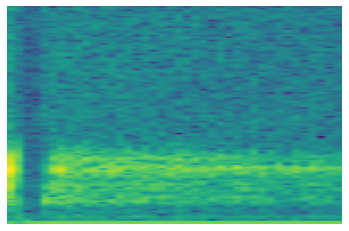

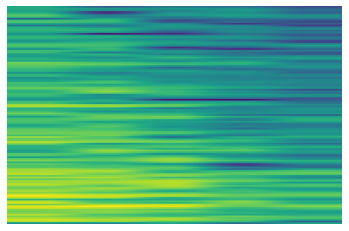

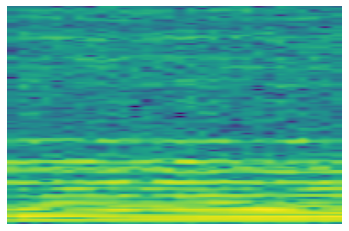

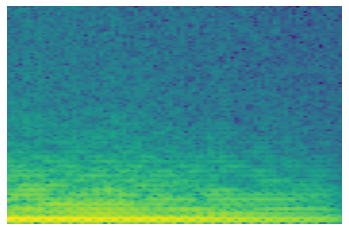

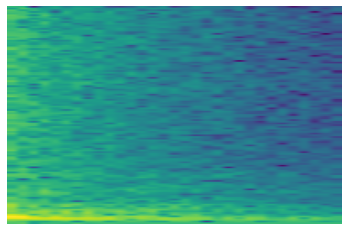

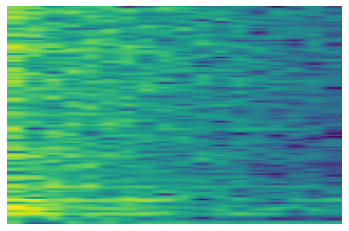

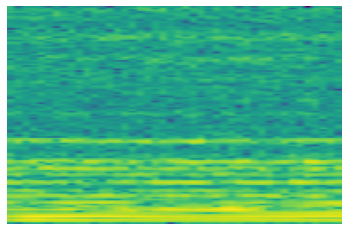

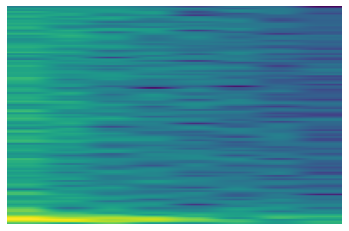

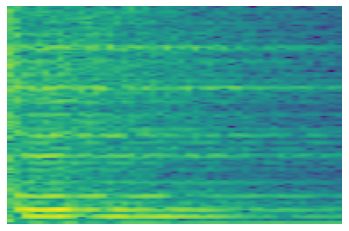

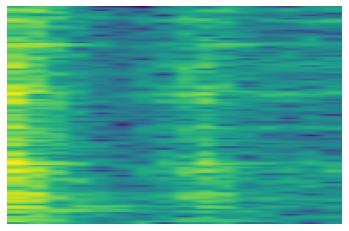

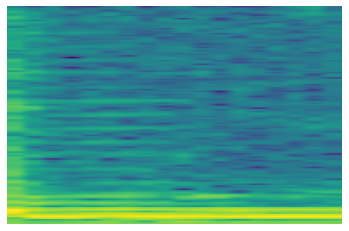

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

for i,wav_file in enumerate(os.listdir('./samples/')):
    Fs, aud = wavfile.read('./samples/'+wav_file)
    fig, axs = plt.subplots() 
    axs.set_axis_off() 
    powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(aud[:,0], Fs=Fs)
    title = f"Sample {i}"
    plt.savefig(f"spectrograms/{wav_file}-spec.png", bbox_inches="tight")
    plt.show()



### Entries for table of the tune samples

In [40]:
for i,w in wav_files:
    print(f"""    \\begin{{subfigure}}{{0.23\\textwidth}}
      \\includegraphics[width=3cm]{{titletune/buttons/{w}-spec.png}}%
      \\makebox[0pt][r]{{%
        \\raisebox{{.3cm}}{{%
          \\textattachfile{{src/titletune/{w}}}{{\\includegraphics[width=1.5cm]{{sounds/play.png}}}}%
        }}\hspace*{{0.75cm}}%
      }}%
      \\caption*{{Sample {i+1}}}
    \\end{{subfigure}}""")

    \begin{subfigure}{0.23\textwidth}
      \includegraphics[width=3cm]{titletune/buttons/samples/tune13.mod-1.wav-spec.png}%
      \makebox[0pt][r]{%
        \raisebox{.3cm}{%
          \textattachfile{src/titletune/samples/tune13.mod-1.wav}{\includegraphics[width=1.5cm]{sounds/play.png}}%
        }\hspace*{0.75cm}%
      }%
      \caption*{Sample 1}
    \end{subfigure}
    \begin{subfigure}{0.23\textwidth}
      \includegraphics[width=3cm]{titletune/buttons/samples/tune13.mod-2.wav-spec.png}%
      \makebox[0pt][r]{%
        \raisebox{.3cm}{%
          \textattachfile{src/titletune/samples/tune13.mod-2.wav}{\includegraphics[width=1.5cm]{sounds/play.png}}%
        }\hspace*{0.75cm}%
      }%
      \caption*{Sample 2}
    \end{subfigure}
    \begin{subfigure}{0.23\textwidth}
      \includegraphics[width=3cm]{titletune/buttons/samples/tune13.mod-4.wav-spec.png}%
      \makebox[0pt][r]{%
        \raisebox{.3cm}{%
          \textattachfile{src/titletune/samples/tune13.mod-4.wav}{\includeg

## Create Sheet Music Maybe?

In [107]:
tune_data["song_length"],tune_data["song_positions"]

(9,
 [0,
  1,
  2,
  3,
  4,
  3,
  6,
  7,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

In [105]:
tune_data["patterns_bytes"][0][:16].hex()

'007f100001944f09011d500000000000'

In [112]:

sl = tune_data["song_length"]
pattern_samples = []
for i,p in enumerate(tune_data["song_positions"]):
    if i > sl:
        break
    pattern = tune_data["patterns"][p]
    samples_played = []
    for channels in pattern:
        channel_samples = []
        for quartet in channels:
            #print(i,quartet, ((quartet[0] << 4) | quartet[2]))
            sample_index = ((quartet[0] << 4) | quartet[2])
            period = quartet[1]
            effect = quartet[3]
            channel_samples += [(sample_index, notes_map[period], get_effect(effect))]
        samples_played += [channel_samples]
    pattern_samples += [(p,samples_played)]
pattern_samples[4][1]

[[(1, 'A3', 0), (4, 'F#2', 'Set Speed 09'), (5, 'C3', 0), (0, '0', 0)],
 [(8, 'A#3', 0), (0, '0', 0), (5, 'C3', 'Set Volume 15'), (0, '0', 0)],
 [(6, 'A3', 0), (0, '0', 0), (5, 'C3', 0), (10, 'D#3', 0)],
 [(6, 'A3', 0), (0, '0', 0), (5, 'C3', 'Set Volume 25'), (10, 'D3', 0)],
 [(8, 'A#3', 0), (0, '0', 0), (0, '0', 0), (0, '0', 0)],
 [(8, 'A#3', 0), (0, '0', 0), (5, 'C3', 'Set Volume 15'), (10, 'C3', 0)],
 [(6, 'A3', 0), (0, '0', 0), (5, 'C3', 0), (0, '0', 0)],
 [(1, 'A3', 0), (0, '0', 0), (5, 'C3', 'Set Volume 25'), (10, 'G3', 0)],
 [(2, 'D3', 0), (0, '0', 0), (0, '0', 0), (0, '0', 0)],
 [(8, 'B3', 0),
  (0, '0', 0),
  (5, 'C3', 'Set Volume 15'),
  (0, '0', 'Set Volume 00')],
 [(8, 'B3', 0), (0, '0', 0), (5, 'C3', 0), (10, 'G3', 'Set Volume 09')],
 [(6, 'A3', 0), (0, '0', 0), (5, 'C3', 'Set Volume 25'), (0, '0', 0)],
 [(0, '0', 0), (0, '0', 0), (0, '0', 0), (0, '0', 'Set Volume 00')],
 [(8, 'B3', 0),
  (0, '0', 0),
  (5, 'C3', 'Set Volume 15'),
  (10, 'G3', 'Set Volume 04')],
 [(6, 'A3

In [147]:
def convertToABC(note):
    if note == '0':
        return 'z'
    n = ""
    if "#" in note:
        n = "^"
        note = note.replace('#','')
    n += note[0]
    o = note[1]
    if o == "2":
        return n+","
    if o == "3":
        return n
    if o == "4":
        return n.lower()
    if o == "5":
        return n.lower() + "'"
    if o == "6":
        return n.lower() + "''"
    return n

def createABCLines(voice):
    pi = 0
    voice_abc = [convertToABC(n) for n in voice]
    for i,v in enumerate(voice_abc):
        if not v or not i:
            continue
        pl = i - pi
        voice_abc[pi] = voice_abc[pi] + str(pl)
        pi = i
    voice_abc[pi] = voice_abc[pi] + str(pl)
    return voice_abc + [":|"] # Add the end tune notation

# Conver the pattern_sample into 4 lists of notes
tunes = []
for p,pattern_sample in pattern_samples:
    pattern_sample_channels = list(map(list, zip(*pattern_sample)))
    pattern_sample_channels_notes = [[x for _,x,_ in ch] for ch in pattern_sample_channels]
    voice1,voice2,voice3,voice4 = pattern_sample_channels_notes
    tunes += [(createABCLines(voice1),
               createABCLines(voice2),
               createABCLines(voice3),
               createABCLines(voice4),)]


In [152]:
import subprocess
from cairosvg import svg2png
import os

abc_filename_prefix = f"./sheet_music/" 

def writeMusicPage(tune, title, pg_no, start, length):
    voice1_abc, voice2_abc, voice3_abc, voice4_abc = tune
    abc_filename = f"title_no_{title}_page_{pg_no}.abc"
    output_file = open(abc_filename_prefix + abc_filename, 'w')
    header = f"""
%abc-2.2
%%pagewidth 25cm
%%header "Example		page: $P"
%%footer "	$T"
%%gutter .5cm
%%barsperstaff 16
%%titleformat R-P-Q-T C1 O1, T+T N1
%%composerspace 0
X: 2 % start of header
T:Tempest 2000 Title Theme
T: Pattern {title}
C: (Howe,Lindsay,Saville)
O: Imagitec Design
R:Derived from tune13.mod
L: 1/8
K: D % scale: C major
"""
    output_file.write(header)
    for i,voice_abc in enumerate([voice1_abc, voice2_abc, voice3_abc, voice4_abc]):
        with_bars = ' '.join([n if (i+1) % 4 else n + ' |' 
                          for i,n in enumerate(voice_abc[start:start+length])])
        if i == 2:
            with_bars = with_bars.replace(' ','')
        output_file.write(f"V:{i+1} name=\"Channel {i+1}\"\n")
        output_file.write(f"{with_bars}\n")
    output_file.close()
    return abc_filename

abc_filenames = []
for title, tune in enumerate(tunes):
    abc_filenames += [writeMusicPage(tune, title, 1, 0, len(tune[0]))]
    #abc_filenames += [writeMusicPage(tune, title, 2, 128, 128)]


for abc_filename in abc_filenames:
    abc_file = abc_filename_prefix + abc_filename
    svg_file = abc_filename_prefix + f"{abc_filename[:-4]}.svg"
    png_file = abc_filename_prefix + f"{abc_filename[:-4]}.png"
    subprocess.run(["abcm2ps", "-g", abc_file, "-O", svg_file])
    print(abc_file, svg_file,png_file)


for fl in os.listdir(abc_filename_prefix):
    if not fl.endswith("svg"):
        continue
    svg_file = abc_filename_prefix + fl
    png_file = abc_filename_prefix + f"{fl[:-4]}.png"
    svg2png(url=svg_file, write_to=png_file)



./sheet_music/title_no_0_page_1.abc:19:134: warning: Line overfull (779pt of 770pt)
./sheet_music/title_no_1_page_1.abc:19:135: warning: Line overfull (784pt of 770pt)
./sheet_music/title_no_2_page_1.abc:19:134: warning: Line overfull (783pt of 770pt)
./sheet_music/title_no_3_page_1.abc:19:134: warning: Line overfull (783pt of 770pt)
./sheet_music/title_no_4_page_1.abc:19:132: warning: Line overfull (784pt of 770pt)
./sheet_music/title_no_5_page_1.abc:19:134: warning: Line overfull (783pt of 770pt)
./sheet_music/title_no_6_page_1.abc:19:138: warning: Line overfull (786pt of 770pt)
./sheet_music/title_no_7_page_1.abc:19:138: warning: Line overfull (786pt of 770pt)
./sheet_music/title_no_8_page_1.abc:19:145: warning: Line overfull (780pt of 770pt)
./sheet_music/title_no_9_page_1.abc:19:134: warning: Line overfull (779pt of 770pt)


abcm2ps-8.14.11 (2020-12-05)
File ./sheet_music/title_no_0_page_1.abc
Output written on ./sheet_music/title_no_0_page_1001.svg (36677 bytes)
./sheet_music/title_no_0_page_1.abc ./sheet_music/title_no_0_page_1.svg ./sheet_music/title_no_0_page_1.png
abcm2ps-8.14.11 (2020-12-05)
File ./sheet_music/title_no_1_page_1.abc
Output written on ./sheet_music/title_no_1_page_1001.svg (38697 bytes)
./sheet_music/title_no_1_page_1.abc ./sheet_music/title_no_1_page_1.svg ./sheet_music/title_no_1_page_1.png
abcm2ps-8.14.11 (2020-12-05)
File ./sheet_music/title_no_2_page_1.abc
Output written on ./sheet_music/title_no_2_page_1001.svg (39721 bytes)
./sheet_music/title_no_2_page_1.abc ./sheet_music/title_no_2_page_1.svg ./sheet_music/title_no_2_page_1.png
abcm2ps-8.14.11 (2020-12-05)
File ./sheet_music/title_no_3_page_1.abc
Output written on ./sheet_music/title_no_3_page_1001.svg (41480 bytes)
./sheet_music/title_no_3_page_1.abc ./sheet_music/title_no_3_page_1.svg ./sheet_music/title_no_3_page_1.png
abcm